In [82]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer
import xgboost as xgb

pd.options.mode.chained_assignment = None

In [19]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [20]:
#Aggregate logins
df['count'] = 1
df.set_index('login_time', inplace=True)
df = df.resample('15T').sum().replace(np.nan, 0)
df

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


(array([719163., 719177., 719194., 719208., 719222., 719236., 719253.,
        719267.]),
 <a list of 8 Text xticklabel objects>)

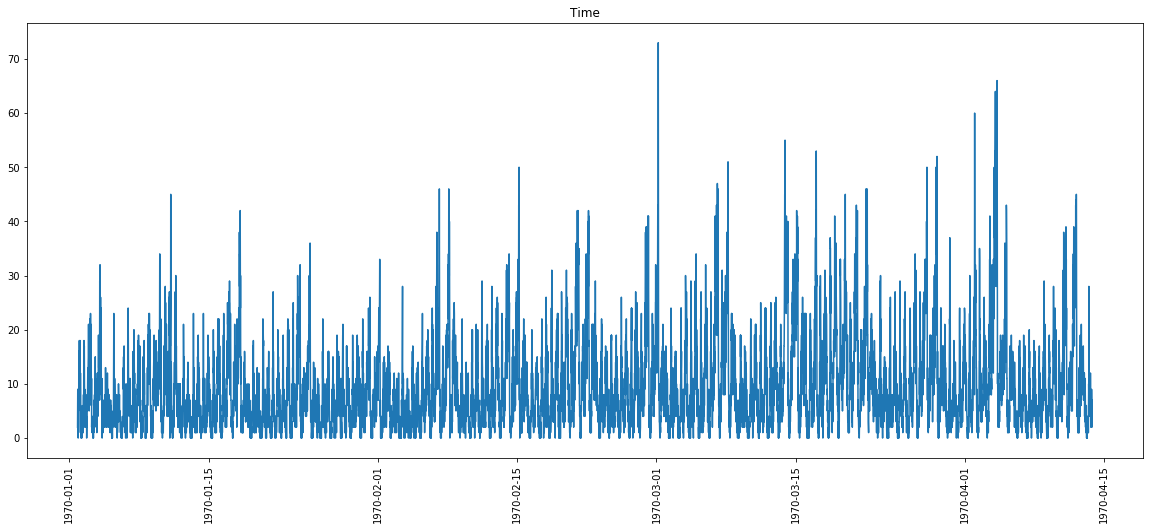

In [22]:
#login visualization
plt.figure(figsize=(20,8))
plt.plot(df)
plt.title('Time')
plt.xticks(rotation=90)

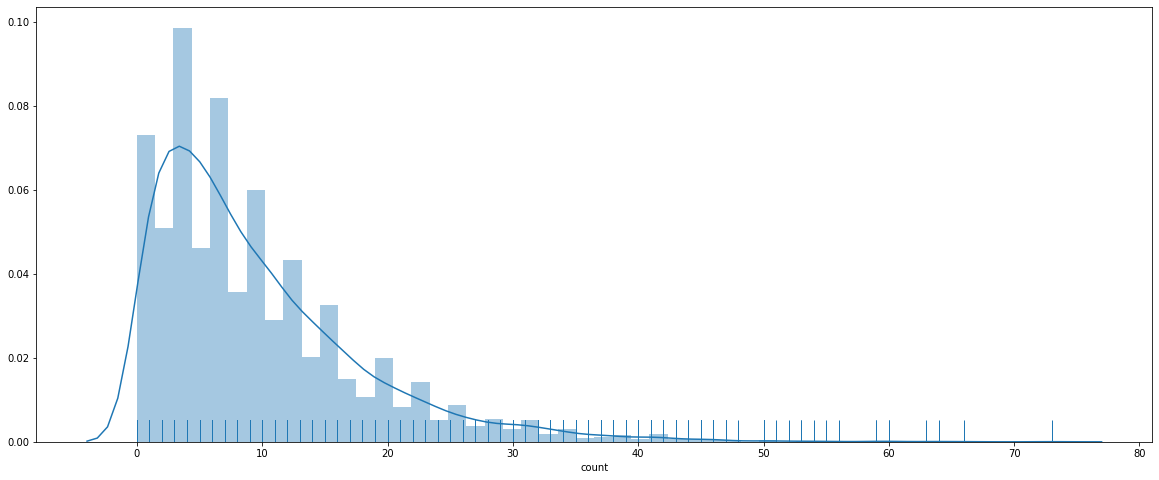

In [28]:
plt.figure(figsize=(20,8))
sn.distplot( a=df["count"], hist=True, kde=True, rug=True )



It can be concluded that the mostly the we have 5 to 10 users each 15 minutes and the extreme values might be for holidays.

In [29]:
#Calculating daily demand
df_daily = pd.read_json('logins.json')
df_daily['count'] = 1
df_daily.set_index('login_time', inplace=True)
df_daily = df_daily.resample('1D').sum().replace(np.nan, 0)
df_daily

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459
...,...
1970-04-09,818
1970-04-10,1009
1970-04-11,1352


(array([719163., 719164., 719165., 719166., 719167., 719168., 719169.,
        719170., 719171., 719172., 719173., 719174., 719175., 719176.,
        719177., 719178., 719179., 719180., 719181., 719182., 719183.,
        719184., 719185., 719186., 719187., 719188., 719189., 719190.,
        719191., 719192., 719193., 719194., 719195., 719196., 719197.,
        719198., 719199., 719200., 719201., 719202., 719203., 719204.,
        719205., 719206., 719207., 719208., 719209., 719210., 719211.,
        719212., 719213., 719214., 719215., 719216., 719217., 719218.,
        719219., 719220., 719221., 719222., 719223., 719224., 719225.,
        719226., 719227., 719228., 719229., 719230., 719231., 719232.,
        719233., 719234., 719235., 719236., 719237., 719238., 719239.,
        719240., 719241., 719242., 719243., 719244., 719245., 719246.,
        719247., 719248., 719249., 719250., 719251., 719252., 719253.,
        719254., 719255., 719256., 719257., 719258., 719259., 719260.,
      

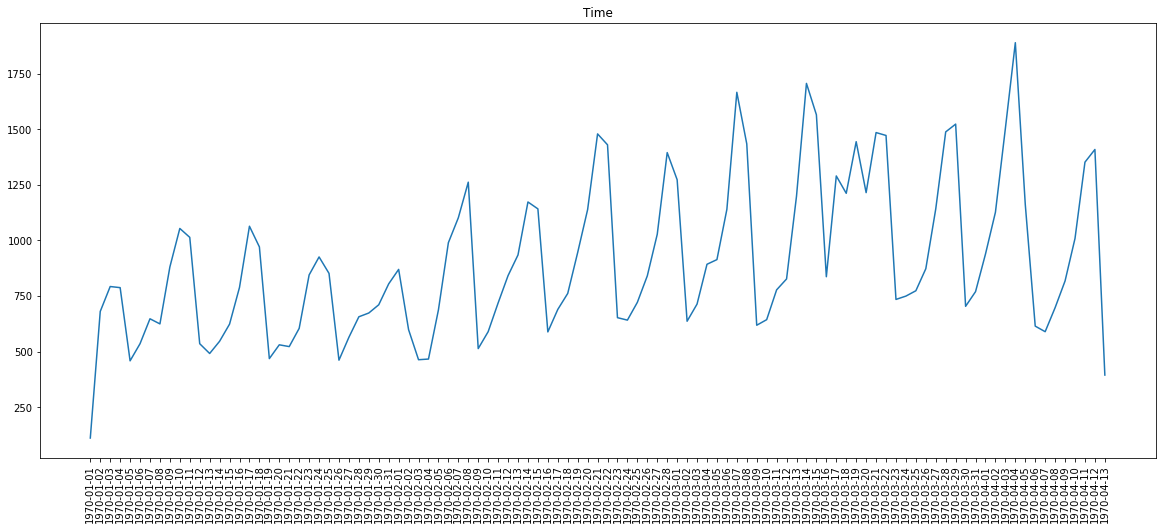

In [39]:
plt.figure(figsize=(20,8))
plt.plot(df_daily)
plt.title('Time')
plt.xticks(df_daily.index.values)
plt.xticks(rotation=90)

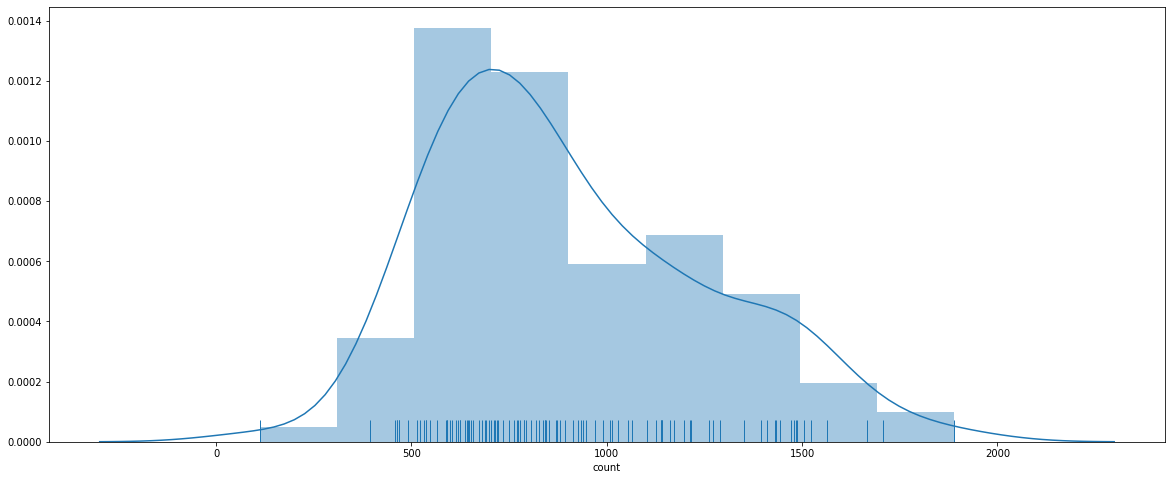

In [40]:
plt.figure(figsize=(20,8))
sn.distplot( a=df_daily["count"], hist=True, kde=True, rug=True )

There are less skewness in daily and around 800 logins per day which is the mean.

In [47]:
#Calculating weekday demand
from datetime import datetime as dt
df_weekday = pd.read_json('logins.json')
df_weekday['week_day'] = df_weekday.login_time.dt.dayofweek
week_day = df_weekday.groupby(['week_day']).count()
week_day.reset_index(inplace=True)


Text(0.5, 1.0, 'user count based on weekdays')

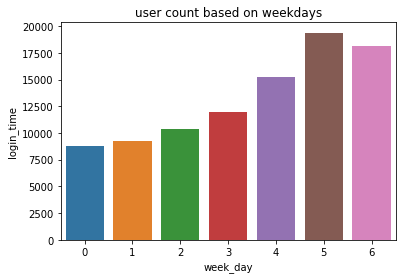

In [50]:
plt.figure()
sn.barplot(week_day.week_day,week_day.login_time)
plt.title('user count based on weekdays')


It seems like number of users are at its highest on Fridya and Saturday and the least on Sunday.

## Part 2 - Experiments and metric design

1- A good metric to track is the average distance the driver has travelled. in order to know if our new incentive has worked we could see how much the average distance has increased per driver showing that they are travelling between the two cities. Also another metric would be to see how many times a driver appears in both cities in a day. meaning that it has travelled between cities. That is a good way to know if the incentive has worked or not.

2- my experiment would be to look at number of times the drivers have travelled between the cities post incentive and before incentive and by looking at the data it becomes clear if the incentive was successful. for statistical test I will look at the p value showing that if the change has been significant or not.

3- Looking at the p value we would be able to see if our incentive was significant or not. if not maybe we could provide them with a higher rate for driving between cities to make it worth their time.

In [52]:
df_ultim = pd.read_json("ultimate_data_challenge.json")
df_ultim.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


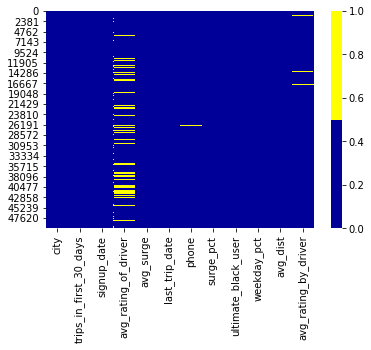

In [54]:
cols = df_ultim.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sn.heatmap(df_ultim[cols].isnull(), cmap=sn.color_palette(colours))

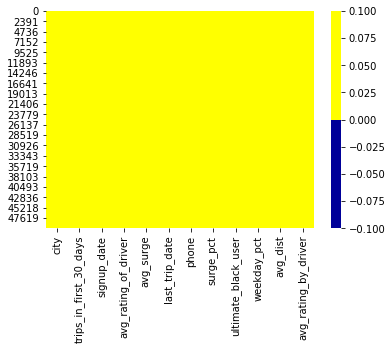

In [55]:
df_ultim = df_ultim.dropna()
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.Full yellow means nothing is missing
sn.heatmap(df_ultim[cols].isnull(), cmap=sn.color_palette(colours))

In [56]:
df_ultim.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


In [63]:
df_ultim['signup_date'] = pd.to_datetime(df_ultim['signup_date'])
df_ultim['last_trip_date'] = pd.to_datetime(df_ultim['last_trip_date'])

In [64]:
latest_date = df_ultim.last_trip_date.max()
print(latest_date)

2014-07-01 00:00:00


In [65]:
from datetime import timedelta
filter_date = latest_date - timedelta(days=30)
print(filter_date)

2014-06-01 00:00:00


In [70]:
df_ultim['retained']=0
df_ultim.retained[df_ultim.last_trip_date>=filter_date]=1


C:\Users\a_raf\Anaconda3\envs\Springboard\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,1
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,0
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0


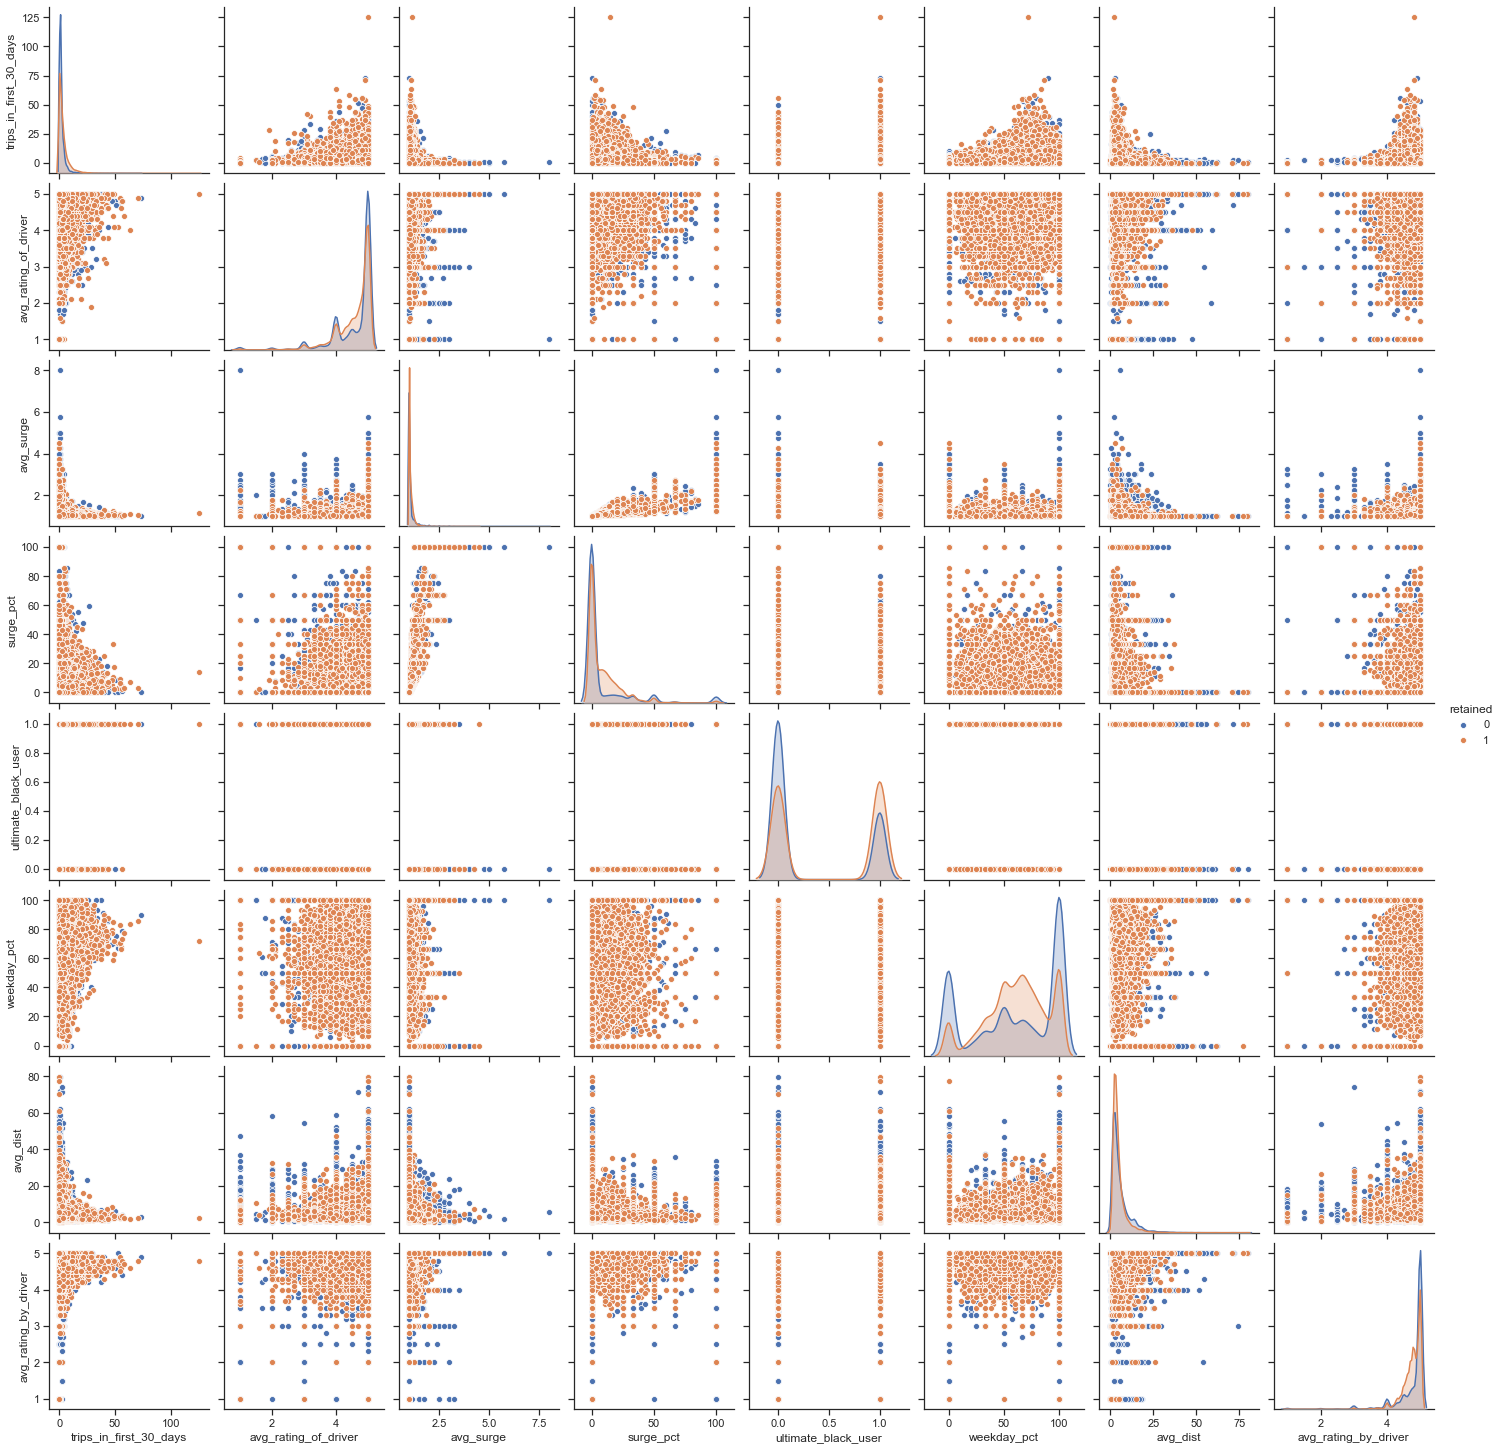

In [76]:
filtered_col=['signup_date','last_trip_date']
filtered_df = df_ultim.drop(columns=filtered_col)
sn.pairplot(filtered_df, hue='retained')

In [79]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
for col in ['city','phone','ultimate_black_user']:
    filtered_df[[col]] = labelencoder.fit_transform(filtered_df[[col]])
filtered_df

C:\Users\a_raf\Anaconda3\envs\Springboard\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,1,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0,1
1,0,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0,0
2,0,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0,0
3,1,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9,1
4,2,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...
49993,0,3,4.8,1.11,1,11.1,1,55.6,2.53,4.7,1
49994,0,1,4.6,1.44,1,37.5,0,25.0,2.25,4.5,0
49995,1,0,5.0,1.00,1,0.0,0,100.0,5.63,4.2,1
49997,2,0,5.0,1.00,0,0.0,1,100.0,3.86,5.0,0


In [80]:
X = filtered_df.drop(columns=['retained']).values
y= filtered_df.retained.values

In [81]:
from sklearn.model_selection import train_test_split

#Splitting data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=111,
                                                    stratify=y)

In [83]:
def report(model, X_train, y_train, X_test, y_test):
    """This function creates trains and tests given model and prints the accuracy report"""
    model.fit(X_train, y_train)
    y_tr_predict = model.predict(X_train)
    print("Model Training Score")
    print(classification_report(y_train, y_tr_predict))
    
    y_test_predict = model.predict(X_test)
    print("Model Test Score")
    print(classification_report(y_test, y_test_predict))
    
    
    return(model)

In [84]:
model = report(xgb.XGBClassifier(scale_pos_weight=5),X_train, y_train, X_test, y_test)

Model Training Score
              precision    recall  f1-score   support

           0       0.93      0.45      0.61     17087
           1       0.55      0.95      0.70     11924

    accuracy                           0.66     29011
   macro avg       0.74      0.70      0.65     29011
weighted avg       0.77      0.66      0.65     29011

Model Test Score
              precision    recall  f1-score   support

           0       0.92      0.45      0.60      7323
           1       0.54      0.94      0.69      5111

    accuracy                           0.65     12434
   macro avg       0.73      0.70      0.65     12434
weighted avg       0.77      0.65      0.64     12434



In [85]:
def feature_imp(model,X_names,num=30):
    """ This function creates a plot showing the feature importance of the model provided to it"""
    importance = list(model.feature_importances_)
    importance,X_names = zip(*sorted(zip(importance, X_names),reverse=True))
    importance=list(importance)
    X_names=list(X_names)
    plt.figure(figsize=(20,8))
    sns.barplot(x=X_names[:num],y=importance[:num])
    plt.xticks(rotation=90)
    #return(importance,X_names)

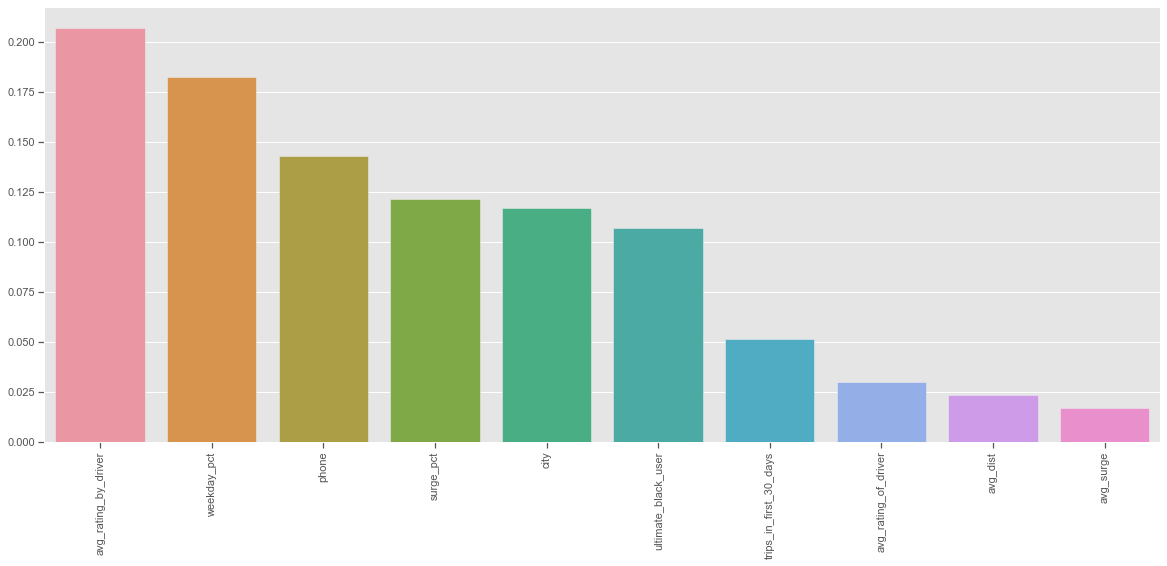

In [86]:
X_names = filtered_df.drop(columns=['retained']).columns
feature_imp(model,X_names, num=len(X_names))

For the model selection I chose to use XGboost for classification in order to perform feature importance analysis. The model is not so great for predicting all of the customers who will not use the system but out of the ones that it considers that they will not use the system it 93% accurate. 

The most important factor for predecting customer retention is the driver rating which is was pretty evident and weekday pct. also it is notable to see how diffrent cellphone operation system might affect user retention, meanining one os might be easier to use than the other.